In [147]:
import io                     # <-- to hold the PNG in RAM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import Bbox

from pyfonts import load_google_font

plt.rcParams['font.family'] = ['Open Sans']
plt.rcParams['font.weight'] = "medium"

output = rf"D:\World Bank\Data-Portal-Brief-Generator\Graphs" 

bold_font = load_google_font("Open Sans", weight="bold")
semibold_font = load_google_font("Open Sans", weight="medium")
legend_font = load_google_font("Open Sans", weight="medium")
legend_font.set_size(13)

colors_by_component = {
    "Education":{"text":"#e95d4e","line":"#0077b6"},
    "Health":{"text":"#bb0089","line":"#00b4d8"},
    "Labor":{"text":"#007bac","line":"#90e0ef"},
}

def my_formatter(x, pos):
    if x.is_integer():
        return str(int(x))
    else:
        return str(x)
    
def generate_random_list(len=3):
    random_sum = 0
    while random_sum!=1:
        random_numbers = np.random.dirichlet(np.ones(len), size=1)[0]
        random_sum = sum(random_numbers)

    return random_numbers

def plot_hci_stage(
    x_main: float,
    x_top95: float,
    x_region: float,
    x_income: float,
    components: tuple[float, float, float],
    component_labels: tuple[str, str, str],
    title: str,
    *,
    ax=None,
    xlim: tuple[float, float] = (0, 1),
    show_value_label: bool = True,
    line_y_positions: tuple[float, float] = (0.0, -.15),
    scatter_styles: dict | None = None,
    segment_colors: tuple[str, str, str] = ("#E95D4E", "#FAC723", "#0CB2AF"),  # red blue yellow
    figsize: tuple[int, int] = (5, 1.5),
):
    """Plot a two‑line decomposition chart that visually mimics the reference image.

    Parameters
    ----------
    x_main, x_top95, x_region
        Horizontal positions of the *main*, *top 95‑th percentile*, and *region* points.
    components
        Fractions that split the distance between *main* and *top95* into three
        coloured segments. Must each be in ``[0, 1]`` and sum to ``1``.
    xlim
        Horizontal axis limits.  Default ``(0, 1)`` to match the baseline in the
        reference graphic.
    show_value_label
        Whether to draw the numeric value of ``x_main`` above its marker.
    line_y_positions
        ``(y_scatter, y_decomposition)`` – vertical positions of the two
        horizontal baselines.
    scatter_styles
        Optional dict that can override marker attributes for
        ``{"main": {…}, "top95": {…}, "region": {…}}``.
    segment_colors
        Colours for the three decomposition segments (left→right).
    figsize
        Size of the figure.
    """

    # ------------------------------------------------------------------
    # validation
    # if len(components) != 3:
    #     raise ValueError("components must be a tuple of exactly three values")
    if any(c < 0 or c > 1 for c in components):
        raise ValueError("each component fraction must lie in [0, 1]")
    if abs(sum(components) - 1) > 1e-6:
        raise ValueError("components must sum to 1 (within tolerance)")

    y_scatter, y_decomp = line_y_positions

    # ------------------------------------------------------------------
    # default marker styles (tuned to resemble the screenshot)
    default_styles = {
        "main": dict(
            marker="o",
            s=300,
            color="#E95D4E",  
            edgecolors="#E95D4E",
            linewidths=2,
            zorder=4,
        ),
        "top95": dict(
            marker="o",  # pentagon
            s=300,
            color="#FAC723",   # yellow fill
            edgecolors=None,
            linewidths=1.5,
            zorder=4,
        ),
        "region": dict(
            marker="|",
            s=300,
            facecolors="#E95D4E",  # purple fill
            edgecolors=None,
            linewidths=2.5,
            zorder=4,
        ),
        "income": dict(
            marker="o",
            s=300,
            facecolors="#0CB2AF",
            edgecolors=None,
            linewidths=2.5,
            zorder=4,
        ),

    }

    if scatter_styles:
        # allow user overrides on a key‑by‑key basis
        for key, overrides in scatter_styles.items():
            default_styles.setdefault(key, {}).update(overrides)

    # ------------------------------------------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    # top & bottom baselines (subtle grey)
    ax.hlines(y_scatter, *xlim, color="#f3f3f3", lw=20, zorder=-2)
    # ax.hlines(y_decomp, *xlim, color="black", lw=1)

    # scatter markers
    ax.scatter([x_main], [y_scatter], **default_styles["main"])
    ax.scatter([x_top95], [y_scatter], **default_styles["top95"])
    ax.scatter([x_region], [y_scatter], **default_styles["region"])
    ax.scatter([x_income], [y_scatter], **default_styles["income"])

    # numeric label above the *main* circle
    if show_value_label:
        for x in [x_main, x_top95, x_income]:
            ax.annotate(
                f"{x:.2f}",
                xy=(x, y_scatter),
                xytext=(0, 14),
                textcoords="offset points",
                ha="center",
                va="bottom",
                font=semibold_font,
                fontsize=12,
            )
        ax.annotate(
            f"{x_region:.2f}",
            xy=(x_region, y_scatter),
            xytext=(0, -25),
            textcoords="offset points",
            ha="center",
            va="bottom",
            font=semibold_font,
            fontsize=10,
        )


    # Distance to regional avg
    if x_region>x_main:
        x0 = x_main
        x1 = x_region
    else:
        x0 = x_region
        x1 = x_main

    ax.hlines(
        0,
        x0,
        x1,
        color=default_styles["region"]["facecolors"],
        lw=2.5,
        capstyle="butt",
        zorder=3,
    )


    # ### coloured decomposition segments
    # total_dist = x_top95 - x_main
    # if total_dist <= 0:
    #     raise ValueError("x_top95 must be greater than x_main (positive distance)")

    # cum_x = x_main
    # for i in range(0, len(components)):
    #     frac = components[i]
    #     colour = segment_colors[i]
    #     frac_label = component_labels[i]
    #     next_x = cum_x + frac * total_dist
    #     next_x_bound = next_x - 0.002
    #     ax.hlines(
    #         y_decomp,
    #         cum_x,
    #         next_x,
    #         color=colour,
    #         lw=2.5,
    #         capstyle="butt",
    #         zorder=3,
    #     )
    #     ax.vlines(cum_x + 0.002, y_decomp - 0.03, y_decomp + 0.03, color=colour, lw=2.5, zorder=5)
    #     ax.vlines(next_x_bound, y_decomp - 0.03, y_decomp + 0.03, color=colour, lw=2.5, zorder=5)

    #     ax.annotate(
    #         f"{frac_label} ({frac*100:.0f}%)",
    #         xy=(cum_x, y_decomp - 0.05),
    #         xytext=(0, -15),
    #         textcoords="offset points",
    #         ha="left",
    #         va="bottom",
    #         color=colour,
    #         fontsize=10,
    #     )

    #     cum_x = next_x
    
    # ax.vlines(x_top95, y_decomp - 0.12, y_decomp + 0.12, color=colour, lw=3)

    # ------------------------------------------------------------------
    # cosmetics – limits, ticks, title, spines
    ax.set_xlim([-.02,1.02])
    ax.set_xticks(xlim)
    ax.tick_params('both', length=10, width=0)
    ax.set_yticks([])

    # Add small black lines in the axis limits 
    ax.vlines(xlim, -0.041, +0.042, color="black", lw=1, zorder=5)

    # ensure markers / labels aren\'t clipped at the top
    ax.set_ylim(y_scatter - 0.1, y_scatter + 0.13)

    ax.set_title(title, loc="left", font=bold_font, fontsize=15, weight="bold", pad=6)

    for spine in ("left", "top", "right", "bottom"):
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_position('zero')   
    
    plt.tight_layout()


    return fig, ax

def plot_hci_stage_subcomponent(
    x_main: float,
    x_top95: float,
    x_region: float,
    x_income: float,
    components: tuple[float, float, float],
    component_labels: tuple[str, str, str],
    title: str,
    *,
    ax=None,
    xlim: tuple[float, float] = (0, 1),
    show_value_label: bool = True,
    line_y_positions: tuple[float, float] = (0.0, -.15),
    scatter_styles: dict | None = None,
    segment_colors: tuple[str, str, str] = ("#E95D4E", "#FAC723", "#0CB2AF"),  # red blue yellow
    figsize: tuple[int, int] = (5, 1.5),
    round_decimals: int = 2,
):
    """Plot a two‑line decomposition chart that visually mimics the reference image.

    Parameters
    ----------
    x_main, x_top95, x_region
        Horizontal positions of the *main*, *top 95‑th percentile*, and *region* points.
    components
        Fractions that split the distance between *main* and *top95* into three
        coloured segments. Must each be in ``[0, 1]`` and sum to ``1``.
    xlim
        Horizontal axis limits.  Default ``(0, 1)`` to match the baseline in the
        reference graphic.
    show_value_label
        Whether to draw the numeric value of ``x_main`` above its marker.
    line_y_positions
        ``(y_scatter, y_decomposition)`` – vertical positions of the two
        horizontal baselines.
    scatter_styles
        Optional dict that can override marker attributes for
        ``{"main": {…}, "top95": {…}, "region": {…}}``.
    segment_colors
        Colours for the three decomposition segments (left→right).
    figsize
        Size of the figure.
    """

    # ------------------------------------------------------------------
    # validation
    # if len(components) != 3:
    #     raise ValueError("components must be a tuple of exactly three values")
    if any(c < 0 or c > 1 for c in components):
        raise ValueError("each component fraction must lie in [0, 1]")
    if abs(sum(components) - 1) > 1e-6:
        raise ValueError("components must sum to 1 (within tolerance)")

    y_scatter, y_decomp = line_y_positions

    # ------------------------------------------------------------------
    # default marker styles (tuned to resemble the screenshot)
    default_styles = {
        "main": dict(
            marker="o",
            s=300,
            color="#E95D4E",  
            edgecolors="#E95D4E",
            linewidths=2,
            zorder=4,
        ),
        "top95": dict(
            marker="o",  # pentagon
            s=300,
            color="#FAC723",   # yellow fill
            edgecolors=None,
            linewidths=1.5,
            zorder=4,
        ),
        "region": dict(
            marker="|",
            s=300,
            facecolors="#E95D4E",  # purple fill
            edgecolors=None,
            linewidths=2.5,
            zorder=4,
        ),
        "income": dict(
            marker="o",
            s=300,
            facecolors="#0CB2AF",
            edgecolors=None,
            linewidths=2.5,
            zorder=4,
        ),

    }

    if scatter_styles:
        # allow user overrides on a key‑by‑key basis
        for key, overrides in scatter_styles.items():
            default_styles.setdefault(key, {}).update(overrides)

    # ------------------------------------------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    # top & bottom baselines (subtle grey)
    ax.hlines(y_scatter, *xlim, color="#ffffff", lw=20, zorder=-2)
    # ax.hlines(y_decomp, *xlim, color="black", lw=1)

    # scatter markers
    ax.scatter([x_main], [y_scatter], **default_styles["main"])
    ax.scatter([x_top95], [y_scatter], **default_styles["top95"])
    ax.scatter([x_region], [y_scatter], **default_styles["region"])
    ax.scatter([x_income], [y_scatter], **default_styles["income"])

    # numeric label above the *main* circle
    if show_value_label:
        for x in [x_main, x_top95, x_income]:
            ax.annotate(
                f"{x:.{round_decimals}f}",
                xy=(x, y_scatter),
                xytext=(0, 14),
                textcoords="offset points",
                ha="center",
                va="bottom",
                font=semibold_font,
                fontsize=12,
            )
        ax.annotate(
            f"{x_region:.{round_decimals}f}",
            xy=(x_region, y_scatter),
            xytext=(0, -25),
            textcoords="offset points",
            ha="center",
            va="bottom",
            font=semibold_font,
            fontsize=10,
        )


    # Distance to regional avg
    if x_region>x_main:
        x0 = x_main
        x1 = x_region
    else:
        x0 = x_region
        x1 = x_main

    ax.hlines(
        0,
        x0,
        x1,
        color=default_styles["region"]["facecolors"],
        lw=2.5,
        capstyle="butt",
        zorder=3,
    )

    # ------------------------------------------------------------------
    # cosmetics – limits, ticks, title, spines
    formatter = FuncFormatter(my_formatter)

    xmin, xmax = xlim
    range_x = xmax - xmin
    ax.set_xlim([xmin-.1*range_x,xmax+.07*range_x])
    ax.set_xticks([xmin, round(xmax)])
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params('both', length=10, width=0)
    ax.set_yticks([])

    # Add small black lines in the axis limits 
    ax.vlines(xlim, -0.041, +0.042, color="black", lw=1, zorder=5)

    # ensure markers / labels aren\'t clipped at the top
    ax.set_ylim(y_scatter - 0.1, y_scatter + 0.13)

    ax.set_title(f"      {title}", loc="left", font=bold_font, fontsize=13, weight="bold", pad=6)

    for spine in ("left", "top", "right", "bottom"):
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_position('zero')   
    
    ax.set_facecolor("none")


    return fig, ax

def add_legend(fig):
    legend_elements = [
        # Kenya  ─ red filled circle
        Line2D([0], [0],
            marker='o', linestyle='',
            markersize=12, markerfacecolor='#E95D4E', markeredgecolor='#E95D4E',
            label='Latest Available data for Kenya'),

        # Income group  ─ blue filled circle
        Line2D([0], [0],
            marker='o', linestyle='',
            markersize=12, markerfacecolor='#0CB2AF', markeredgecolor='#0CB2AF',
            label='Avg. for Lower Middle Income'),

        # Region  ─ red vertical bar   (use the same linewidth & colour as on chart)
        Line2D([0], [0],
                marker='|',linestyle='', markersize=12,
                color='#E95D4E', linewidth=30,
                markeredgewidth=3,      #  ← thickness of the bar
                label='Avg. for Sub-Saharan Africa'),

        # Gold standard  ─ yellow filled circle (with thin dark edge if you like)
        Line2D([0], [0],
            marker='o', linestyle='',
            markersize=12, markerfacecolor='#FAC723', markeredgecolor='#FAC723',
            label='Top-performing Peer'),
    ]

    # Place the legend above the stacked rows, centered
    fig.legend(
        handles=legend_elements,
        loc='upper center',           # top-centre of the whole figure
        bbox_to_anchor=(0.5, 0.947),   # a bit above the title
        ncols=2,
        frameon=False,                # no legend box
        prop=legend_font,
        handletextpad=0.2,
        labelspacing=0.3,
    )
    return fig

def premultiply_with_white(hex_color: str, alpha_equiv: float = 0.20) -> str:
    """
    Return a new hex colour that looks like `hex_color` rendered with the
    given alpha_equiv on a white background, but without any transparency.
    """
    r, g, b = mcolors.to_rgb(hex_color)            # 0-1 floats
    # Blend: new = α*orig + (1-α)*white
    r2 = alpha_equiv * r + (1 - alpha_equiv) * 1   # white = 1,1,1
    g2 = alpha_equiv * g + (1 - alpha_equiv) * 1
    b2 = alpha_equiv * b + (1 - alpha_equiv) * 1
    return mcolors.to_hex((r2, g2, b2), keep_alpha=False)   # opaque

def plot_two_line_decomposition(
    x_main: float,
    x_top95: float,
    x_region: float,
    x_income: float,
    components: tuple[float, float, float],
    component_labels: tuple[str, str, str],
    title: str,
    *,
    ax=None,
    xlim: tuple[float, float] = (0, 1),
    show_value_label: bool = True,
    line_y_positions: tuple[float, float] = (0.0, 0.0),
    scatter_styles: dict | None = None,
    component_colors: tuple[str, str, str] = ("#E95D4E", "#FAC723", "#0CB2AF"),  
    segment_colors: tuple[str, str, str] = ("#E95D4E", "#FAC723", "#0CB2AF"),  # red blue yellow
    figsize: tuple[int, int] = (5, 1.5),
):
    """Plot a two‑line decomposition chart that visually mimics the reference image.

    Parameters
    ----------
    x_main, x_top95, x_region
        Horizontal positions of the *main*, *top 95‑th percentile*, and *region* points.
    components
        Fractions that split the distance between *main* and *top95* into three
        coloured segments. Must each be in ``[0, 1]`` and sum to ``1``.
    xlim
        Horizontal axis limits.  Default ``(0, 1)`` to match the baseline in the
        reference graphic.
    show_value_label
        Whether to draw the numeric value of ``x_main`` above its marker.
    line_y_positions
        ``(y_scatter, y_decomposition)`` – vertical positions of the two
        horizontal baselines.
    scatter_styles
        Optional dict that can override marker attributes for
        ``{"main": {…}, "top95": {…}, "region": {…}}``.
    segment_colors
        Colours for the three decomposition segments (left→right).
    figsize
        Size of the figure.
    """

    # ------------------------------------------------------------------
    # validation
    # if len(components) != 3:
    #     raise ValueError("components must be a tuple of exactly three values")
    if any(c < 0 or c > 1 for c in components):
        raise ValueError("each component fraction must lie in [0, 1]")
    if abs(sum(components) - 1) > 1e-6:
        raise ValueError("components must sum to 1 (within tolerance)")

    y_scatter, y_decomp = line_y_positions

    # ------------------------------------------------------------------
    # default marker styles (tuned to resemble the screenshot)
    default_styles = {
        "main": dict(
            marker="o",
            s=300,
            color="#E95D4E",  
            edgecolors="#E95D4E",
            linewidths=2,
            zorder=20,
        ),
        "top95": dict(
            marker="o",  # pentagon
            s=300,
            color="#FAC723",   # yellow fill
            edgecolors=None,
            linewidths=1.5,
            zorder=20,
        ),
        "region": dict(
            marker="|",
            s=300,
            facecolors="#E95D4E",  # purple fill
            edgecolors=None,
            linewidths=2.5,
            zorder=20,
        ),
        "income": dict(
            marker="o",
            s=300,
            facecolors="#0CB2AF",
            edgecolors=None,
            linewidths=1.5,
            zorder=20,
        ),

    }

    if scatter_styles:
        # allow user overrides on a key‑by‑key basis
        for key, overrides in scatter_styles.items():
            default_styles.setdefault(key, {}).update(overrides)

    # ------------------------------------------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    # top & bottom baselines (subtle grey)
    ax.hlines(y_scatter, *xlim, color="#f3f3f3", lw=20, zorder=-2)
    # ax.hlines(y_decomp, *xlim, color="black", lw=1)

    # scatter markers
    ax.scatter([0], [y_scatter], **default_styles["main"])
    ax.scatter([1], [y_scatter], **default_styles["top95"])
    # ax.scatter([x_region], [y_scatter], **default_styles["region"])
    # ax.scatter([x_income], [y_scatter], **default_styles["income"])

    # numeric label above the *main* circle
    if show_value_label:
        for pos, x in enumerate([x_main, x_top95]):
            ax.annotate(
                f"{x:.2f}",
                xy=(pos, y_scatter),
                xytext=(0, 14),
                textcoords="offset points",
                ha="center",
                va="bottom",
                font=semibold_font,
                fontsize=12,
            )

    # # Distance to regional avg
    # if x_region>x_main:
    #     x0 = x_main
    #     x1 = x_region
    # else:
    #     x0 = x_region
    #     x1 = x_main

    # ax.hlines(
    #     0,
    #     x0,
    #     x1,
    #     color="#E95D4E",
    #     lw=2.5,
    #     capstyle="butt",
    #     zorder=3,
    # )

    ### coloured decomposition segments
    cum_frac = 0
    for i, component in enumerate(component_labels):
        frac = components[i]
        colour = colors_by_component[component]["line"]
        legend_color = colors_by_component[component]["text"]
        frac_label = component_labels[i]
        next_frac = cum_frac + frac
        center_frac = cum_frac + frac/2
        ax.hlines(
            y_decomp,
            cum_frac,
            next_frac,
            color=premultiply_with_white(legend_color, alpha_equiv=0.65),
            lw=4,
            # alpha=0.3,
            capstyle="round",
            zorder=10,
        )
        # Segment bounds
        # ax.vlines(cum_frac + 0.0035, y_decomp - 0.013, y_decomp + 0.013, color=colour, lw=2.5, zorder=35)
        # ax.vlines(cum_frac, y_decomp - 0.013, y_decomp + 0.013, color=colour, lw=1.5, zorder=35)
        if frac>0.05:
            ax.annotate(
                f"{frac_label} ({frac*100:.0f}%)",
                xy=(center_frac, y_decomp),
                xytext=(0, -25),
                textcoords="offset points",
                ha="center",
                va="bottom",
                font=bold_font,
                color=legend_color,
                fontsize=12,
            )

        cum_frac = next_frac
    # ax.vlines(1, y_decomp - 0.013, y_decomp + 0.013, color=colour, lw=1.5, zorder=35)

    # ------------------------------------------------------------------
    # cosmetics – limits, ticks, title, spines
    ax.set_xlim([-.04,1.04])
    ax.set_xticks([])
    ax.tick_params('both', length=10, width=0)
    ax.set_yticks([])

    # Add small black lines in the axis limits 
    # ax.vlines(xlim, -0.0265, +0.0265, color="black", lw=1, zorder=5)

    # ensure markers / labels aren\'t clipped at the top
    ax.set_ylim(y_scatter - 0.03, y_scatter + 0.05)

    ax.set_title(title, loc="left", font=bold_font, weight="bold", fontsize=15, pad=0)

    for spine in ("left", "top", "right", "bottom"):
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    plt.tight_layout()
    return fig, ax


def plot_hci_block(
  stage_params, c1_params, c2_params, c3_params=None, c4_params=None, 
):
    total_components = 3 + (1 if c3_params else 0) + (1 if c4_params else 0)
    fig, ax = plt.subplots(figsize=(5, 1.3*total_components), nrows=total_components)
    add_vspace = 0
    
    plot_hci_stage(**stage_params, ax=ax[0])
    plot_hci_stage_subcomponent(**c1_params, ax=ax[1])
    plot_hci_stage_subcomponent(**c2_params, ax=ax[2])
    if c3_params:
        plot_hci_stage_subcomponent(**c3_params, ax=ax[3])
        add_vspace += 0.067
    if c4_params:
        plot_hci_stage_subcomponent(**c4_params, ax=ax[4])
        add_vspace += 0.053

    # Make sure layouts & transforms are finalized
    fig.canvas.draw()
    
    # Create a rounded rectangle in FIGURE space
    rect = patches.FancyBboxPatch(
        (0.12, 0.07),        # lower-left corner (fig coords)
        0.8, 0.6+add_vspace,   # width & height
        boxstyle="round,pad=0.02",     # round corners + a little padding
        edgecolor="none",
        facecolor="#f1f1f1",
        linewidth=2,
        transform=fig.transFigure,     # <<— figure coords, no twirling
        zorder=-5
    )

    # Add it to the FIGURE (not to any single Axes)
    fig.add_artist(rect)

    return fig, ax

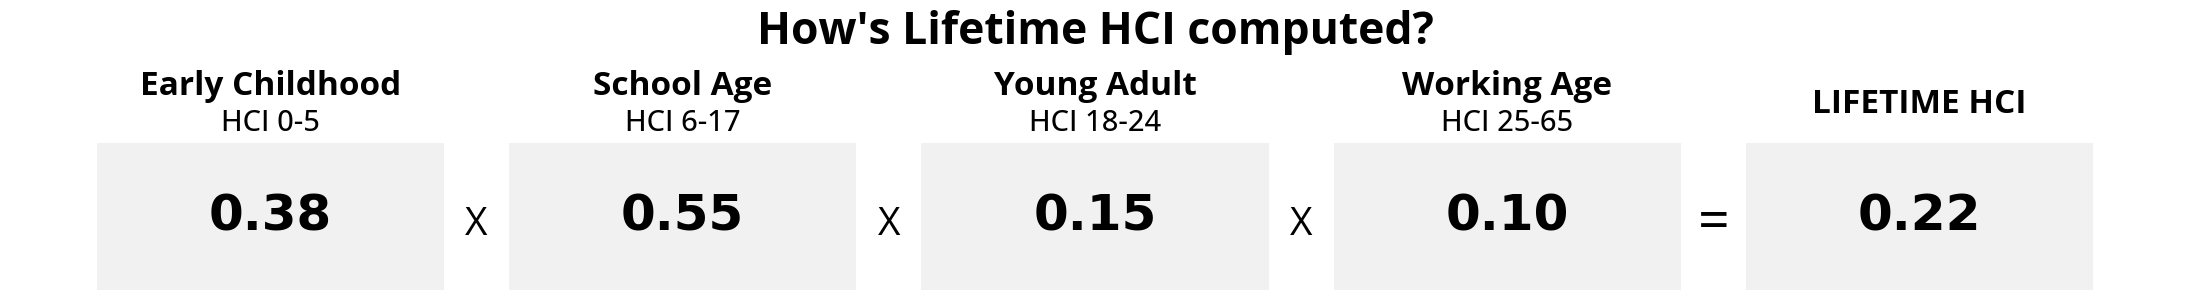

In [246]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# --- Helper Function to Place Icons ---
def place_icon(ax, path, x, y, fixed_height=0.1):
    """
    Reads an image and places it on the axes with a fixed height in data coordinates.

    Args:
        ax (matplotlib.axes.Axes): The axes to draw on.
        path (str): The file path to the icon.
        x (float): The x-coordinate (in data units) for the icon's center.
        y (float): The y-coordinate (in data units) for the icon's center.
        fixed_height (float): The desired height of the icon in data coordinate units.
    """
    try:
        img = plt.imread(path)
    except FileNotFoundError:
        print(f"Icon not found at '{path}'. Please download it and place it in the script's directory.")
        ax.text(x, y, "[icon]", ha='center', va='center', color='red')
        return

    # Get the height of the image in pixels
    img_height_pixels = img.shape[0]

    # Get the axes' aspect ratio and data range
    fig = ax.get_figure()
    
    # Ensure the canvas is drawn to get accurate pixel dimensions
    fig.canvas.draw()
    
    # Get transformation from data to pixel coordinates
    ax_bbox = ax.get_window_extent()
    ax_height_pixels = ax_bbox.height
    data_height_ax = ax.get_ylim()[1] - ax.get_ylim()[0]

    # Calculate the target height in pixels based on the desired data height
    target_height_pixels = (fixed_height / data_height_ax) * ax_height_pixels

    # Calculate the required zoom factor to achieve the target pixel height
    zoom_factor = target_height_pixels / img_height_pixels

    # Create and add the artist
    oi = OffsetImage(img, zoom=zoom_factor)
    box = AnnotationBbox(oi, (x, y), frameon=False, pad=0)
    ax.add_artist(box)


# --- Main Plotting Function ---
def create_hci_plot(hci_early, hci_school, hci_young, hci_work, hci_lifetime):
    """
    Generates a plot visualizing the Human Capital Index (HCI) calculation.

    Args:
        hci_early (float): The HCI value for Early Childhood (0-5).
        hci_school (float): The HCI value for School Age (6-17).
        hci_young (float): The HCI value for Young Adult (18-24).
        hci_work (float): The HCI value for Working Age (25-65).
        hci_lifetime (float): The final Lifetime HCI value.
    """
    # --- Style and Color Definitions ---
    BG_COLOR = '#f1f1f1'      # Light blue for boxes
    TEXT_COLOR = '#000000'    # Dark blue for text
    FONT_NAME = 'sans-serif'  # A clean, modern font

    # --- Setup Figure and Axes ---
    fig, ax = plt.subplots(figsize=(22, 2.5))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off') # Hide axes, ticks, and spines

    # --- Data for Each Column ---
    # We define the properties for each stage in a structured way
    columns = [
        {'title': 'Early Childhood', 'age_range': 'HCI 0-5', 'value': hci_early, 'icon_path': r'C:\Users\Nico\Downloads\icon_childhood.png', 'height':0.18},
        {'title': 'School Age', 'age_range': 'HCI 6-17', 'value': hci_school, 'icon_path': r'C:\Users\Nico\Downloads\icon_school.png', 'height':0.23},
        {'title': 'Young Adult', 'age_range': 'HCI 18-24', 'value': hci_young, 'icon_path': r'C:\Users\Nico\Downloads\icon_young_adult.png', 'height':0.25},
        {'title': 'Working Age', 'age_range': 'HCI 25-65', 'value': hci_work, 'icon_path': r'C:\Users\Nico\Downloads\icon_working_age.png', 'height':0.25},
        {'title': 'LIFETIME HCI', 'age_range': '', 'value': hci_lifetime, 'icon_path': r'C:\Users\Nico\Downloads\icon_lifetime.png', 'height':0.25}
    ]

    # --- Define Layout Positions ---
    x_positions = [0.12, 0.31, 0.50, 0.69, 0.88]
    y_icon = 1
    y_title = 1
    y_age = 0.82
    box_y_start = 0
    box_height = 0.72

    # --- Loop to Create Each Column ---
    for i, col in enumerate(columns):
        x = x_positions[i]

        # 1. Place Icon
        # place_icon(ax, col['icon_path'], x, y_icon-0.15+col["height"]/2, fixed_height=col["height"])

        # 2. Place Title and Age Range Text
        if col['age_range'] == '':
            y_title = (y_title + y_age) / 2  # Center title if no age range

        ax.text(x, y_title, col['title'], ha='center', va='center', color=TEXT_COLOR,
                font=bold_font, fontweight='bold', fontsize=24)
        ax.text(x, y_age, col['age_range'], ha='center', va='center', color=TEXT_COLOR,
                font=semibold_font, fontweight='bold', fontsize=21)

        # 3. Draw the Blue Box (Rectangle)
        box_width = 0.16
        rect = patches.Rectangle(
            (x - box_width / 2, box_y_start),  # bottom-left corner
            box_width,                         # width
            box_height,                        # height
            facecolor=BG_COLOR,
            edgecolor='none',
            linewidth=0
        )
        ax.add_patch(rect)

        # 4. Place the HCI Value inside the box
        ax.text(x, box_y_start + box_height / 2, f"{col['value']:.2f}", ha='center', va='center',
                color=TEXT_COLOR, fontweight='bold', fontsize=36, fontname=FONT_NAME)

        # 5. Place Operators (X and =) between boxes
        if i < 3: # Place 'X' after the first 3 boxes
            ax.text(x_positions[i] + 0.095, 0.32, 'X', ha='center', va='center',
                    color=TEXT_COLOR, fontweight='bold', fontsize=28)
        elif i == 3: # Place '=' after the 4th box
             ax.text(x_positions[i] + 0.095, 0.32, '=', ha='center', va='center',
                    color=TEXT_COLOR, fontweight='bold', fontsize=40)

    # --- Display the Plot ---
    plt.tight_layout()
    
    return fig, ax

# === EXAMPLE USAGE ===
# Replace these numbers with your actual data
if __name__ == "__main__":
    # Sample data
    early_childhood_hci = 0.85
    school_age_hci = 0.75
    young_adult_hci = 0.88
    working_age_hci = 0.92
    
    # NOTE: The calculation is multiplicative, so the final HCI is a product of the components.
    # The actual World Bank HCI calculation is more complex, but for this visual,
    # we can represent it as a multiplication.
    lifetime_hci_calculated = early_childhood_hci * school_age_hci * young_adult_hci * working_age_hci
    
    # Call the function with your data
    fig, ax = create_hci_plot(
       0.38, .55, .15, .1, .22
    )
    fig.suptitle("How's Lifetime HCI computed?", font=bold_font, fontsize=32, weight="bold", y=1.18)
    fig.savefig(rf"{output}\HCI_computation.png", dpi=600, bbox_inches='tight', pad_inches=0)



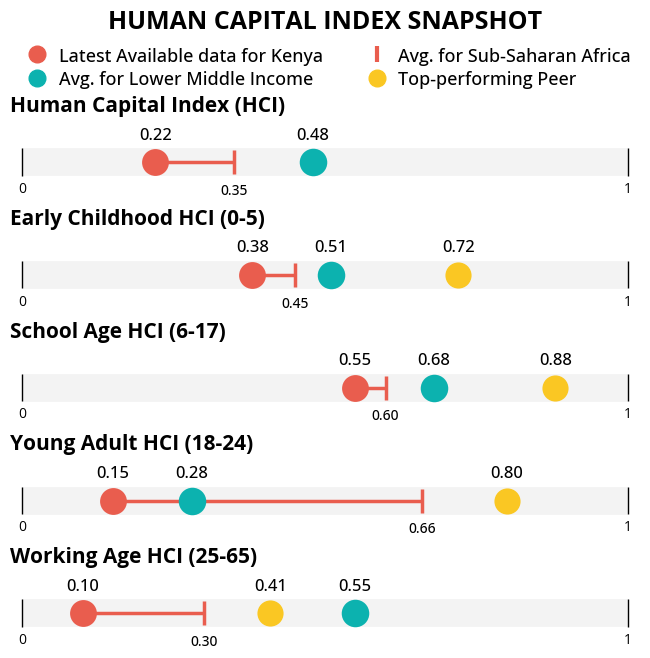

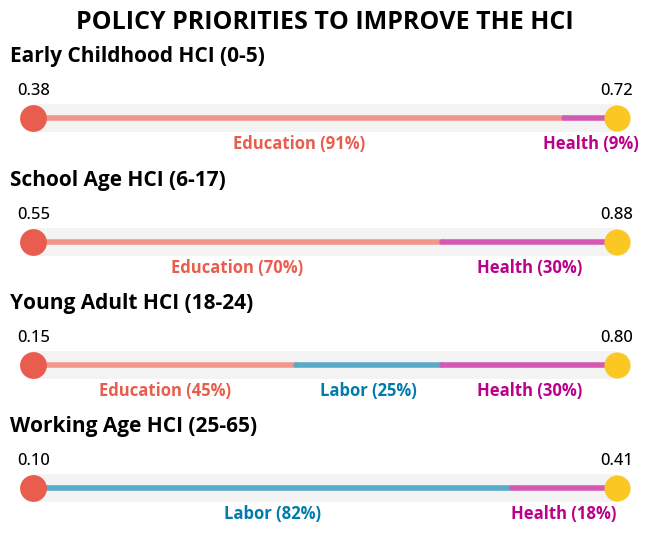

In [148]:
# -------------------------------------------------------------
# 1.  Prepare the parameter sets you want to stack
# -------------------------------------------------------------
cases = [
    dict(
        x_main=0.22, x_top95=52, x_region=0.35, x_income=0.48,
        components=generate_random_list(2),
        component_labels=("Education", "Health"),
        title="Human Capital Index (HCI)",
    ),
    dict(
        x_main=0.38, x_top95=0.72, x_region=0.45, x_income=0.51,
        components=[.91, .09],
        component_labels=("Education", "Health"),
        title="Early Childhood HCI (0-5)",
    ),
    dict( 
        x_main=0.55, x_top95=0.88, x_region=0.60, x_income=0.68,
        components=[.7, .3],
        component_labels=("Education", "Health"),
        title="School Age HCI (6-17)",
    ),
    dict(
        x_main=0.15, x_top95=0.80, x_region=0.66, x_income=0.28,
        components=[.45, .12+.09+.04, .3],
        component_labels=("Education", "Labor", "Health"),
        title="Young Adult HCI (18-24)",
    ),
    dict(
        x_main=0.1, x_top95=0.41, x_region=0.30, x_income=0.55,
        components=[.78+.03+.01, .18],
        component_labels=("Labor", "Health"),
        title="Working Age HCI (25-65)",
    ),
]

# -------------------------------------------------------------
# 2.  Create Figure for HCI Stages
# -------------------------------------------------------------
n = len(cases)
container_fig, axes = plt.subplots(
    nrows=n, ncols=1,
    figsize=(7, 1.3*n),
    squeeze=False,
)
axes = axes.flatten()

for ax, params in zip(axes, cases):
    _, ax = plot_hci_stage(**params, ax=ax)  # ← your function
        
container_fig.suptitle("HUMAN CAPITAL INDEX SNAPSHOT", font=bold_font, fontsize=18)
container_fig = add_legend(container_fig)

container_fig.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.81)
container_fig.savefig(rf"{output}\HCI_stages.jpg", dpi=600, bbox_inches='tight', pad_inches=.25, edgecolor="black")

# # Export individual rows
# i = 0
# for ax, params in zip(axes, cases):
#     _, ax = plot_hci_stage(**params, ax=ax)  # ← your function

#     # Now plot single hci stage
#     fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 1.3))
#     _, ax2 = plot_hci_stage(**params, ax=ax2)  # ← your function
#     fig2.savefig(rff"{output}\HCI_stages_{i}.jpg", dpi=600, bbox_inches='tight', pad_inches=.25)
#     i += 1

# -------------------------------------------------------------
# 3.  Create Decomposition Figure for HCI Stages
# -------------------------------------------------------------
cases = cases[1:]
n = len(cases)
container_fig, axes = plt.subplots(
    nrows=n, ncols=1,
    figsize=(7, 1.3*n),
    squeeze=False,
)
axes = axes.flatten()

for ax, params in zip(axes, cases):
    _, ax = plot_two_line_decomposition(**params, ax=ax)  # ← your function

container_fig.suptitle("POLICY PRIORITIES TO IMPROVE THE HCI", font=bold_font, fontsize=18)
container_fig.tight_layout()
# container_fig.show()
plt.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.87)
container_fig.savefig(rf"{output}\stacked_two_line_decomposition.jpg", dpi=600, bbox_inches='tight', pad_inches=.25, edgecolor="black")


## Version with blocks

### Global

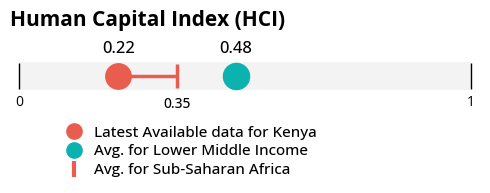

In [166]:
cases = [
    dict(
        x_main=0.22, x_top95=52, x_region=0.35, x_income=0.48,
        components=generate_random_list(2),
        component_labels=("Education", "Health"),
        title="Human Capital Index (HCI)",
    ),
]

def add_legend(fig):
    legend_font = load_google_font("Open Sans", weight="medium")
    legend_font.set_size(11)

    legend_elements = [
        # Kenya  ─ red filled circle
        Line2D([0], [0],
            marker='o', linestyle='',
            markersize=11, markerfacecolor='#E95D4E', markeredgecolor='#E95D4E',
            label='Latest Available data for Kenya'),

        # Income group  ─ blue filled circle
        Line2D([0], [0],
            marker='o', linestyle='',
            markersize=11, markerfacecolor='#0CB2AF', markeredgecolor='#0CB2AF',
            label='Avg. for Lower Middle Income'),

        # Region  ─ red vertical bar   (use the same linewidth & colour as on chart)
        Line2D([0], [0],
                marker='|',linestyle='', markersize=11,
                color='#E95D4E', linewidth=30,
                markeredgewidth=3,      #  ← thickness of the bar
                label='Avg. for Sub-Saharan Africa'),

        # # Gold standard  ─ yellow filled circle (with thin dark edge if you like)
        # Line2D([0], [0],
        #     marker='o', linestyle='',
        #     markersize=12, markerfacecolor='#FAC723', markeredgecolor='#FAC723',
        #     label='Top-performing Peer'),
    ]

    # Place the legend above the stacked rows, centered
    fig.legend(
        handles=legend_elements,
        loc='upper left',           # top-centre of the whole figure
        bbox_to_anchor=(0.1, 0.1),   # a bit above the title
        ncols=1,
        frameon=False,                # no legend box
        prop=legend_font,
        handletextpad=0.3,
        labelspacing=0.3,
    )
    return fig


# -------------------------------------------------------------
# 2.  Create Figure for HCI Stages
# -------------------------------------------------------------
n = len(cases)
container_fig, axes = plt.subplots(
    nrows=n, ncols=1,
    figsize=(5, 1.3*n),
    squeeze=False,
)
axes = axes.flatten()

for ax, params in zip(axes, cases):
    _, ax = plot_hci_stage(**params, ax=ax)  # ← your function
        
container_fig = add_legend(container_fig)

container_fig.tight_layout()

# Transparent background
# container_fig.patch.set_facecolor('#f2f2f2')

# plt.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.81)
container_fig.savefig(rf"{output}\HCI_global.jpg", dpi=600, bbox_inches='tight', pad_inches=0, edgecolor="black")


### Early Childhood

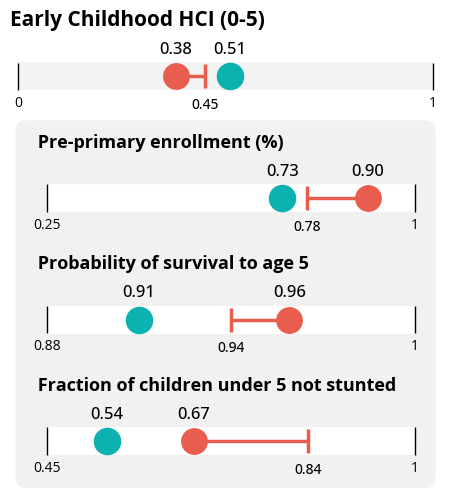

In [150]:
stage_params = {
    'title': 'Early Childhood HCI (0-5)',
    'x_main': 0.38,
    'x_top95': 90,
    'x_region': 0.45,
    'x_income': 0.51,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
}
c1_params = {
    'title': 'Pre-primary enrollment (%)',
    'x_main': 0.904,
    'x_top95': 90,
    'x_region': 0.78,
    'x_income': 0.73,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (.25, 1),
}
c2_params = {
    'title': 'Probability of survival to age 5',
    'x_main': 0.959,
    'x_top95': 90,
    'x_region': 0.94,
    'x_income': 0.91,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (.88, 1),
}
c3_params = {
    'title': 'Fraction of children under 5 not stunted',
    'x_main': 0.67,
    'x_top95': 90,
    'x_region': 0.84,
    'x_income': 0.54,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (.45, 1),
}

fig, ax = plot_hci_block(
    stage_params=stage_params,
    c1_params=c1_params,
    c2_params=c2_params,
    c3_params=c3_params,
)   
fig.savefig(rf"{output}\HCI_stage1.jpg", dpi=600, bbox_inches='tight', pad_inches=.25, edgecolor="black")


### School Age

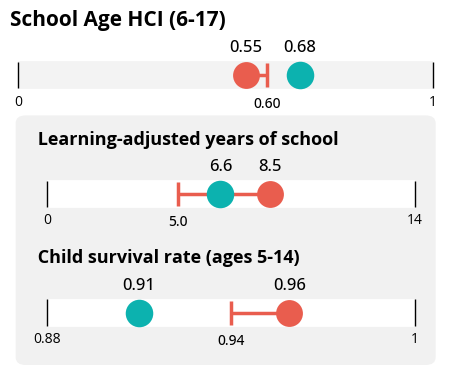

In [151]:
stage_params = {
    'title': 'School Age HCI (6-17)',
    'x_main': 0.55,
    'x_top95': 90,
    'x_region': 0.60,
    'x_income': 0.68,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
}
c1_params = {
    'title': 'Learning-adjusted years of school',
    'x_main': 8.5,
    'x_top95': 90,
    'x_region': 5.0,
    'x_income': 6.6,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (0, 14),
    'round_decimals': 1
}
c2_params = {
    'title': 'Child survival rate (ages 5-14)',
    'x_main': 0.959,
    'x_top95': 90,
    'x_region': 0.94,
    'x_income': 0.91,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (.88, 1),
}

fig, ax = plot_hci_block(
    stage_params=stage_params,
    c1_params=c1_params,
    c2_params=c2_params,
)   
fig.savefig(rf"{output}\HCI_stage2.jpg", dpi=600, bbox_inches='tight', pad_inches=.25, edgecolor="black")


### Young Adults

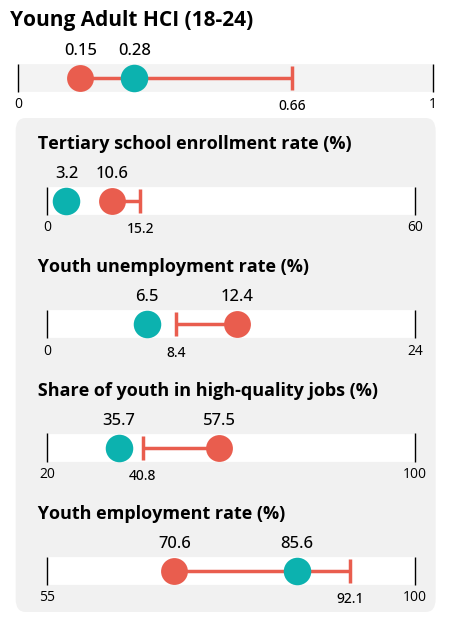

In [152]:
stage_params = {
    'title': 'Young Adult HCI (18-24)',
    'x_main': 0.15,
    'x_top95': 90,
    'x_region': 0.66,
    'x_income': 0.28,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
}
c1_params = {
    'title': 'Tertiary school enrollment rate (%)',
    'x_main': 10.6,
    'x_top95': 9999,
    'x_region': 15.2,
    'x_income': 3.2,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (0, 60),
    'round_decimals': 1
}
c2_params = {
    'title': 'Youth unemployment rate (%)',
    'x_main': 12.4,
    'x_top95': 900000,
    'x_region': 8.4,
    'x_income': 6.5,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (0, 24),
    'round_decimals': 1
}
c3_params = {
    'title': 'Share of youth in high-quality jobs (%)',
    'x_main': 57.5,
    'x_top95': 99999999,
    'x_region': 40.8,
    'x_income': 35.7,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (20, 100),
    'round_decimals': 1
}
c4_params = {
    'title': 'Youth employment rate (%)',
    'x_main': 70.6,
    'x_top95': 99999999,
    'x_region': 92.1,
    'x_income': 85.6,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (55, 100),
    'round_decimals': 1
}

fig, ax = plot_hci_block(
    stage_params=stage_params,
    c1_params=c1_params,
    c2_params=c2_params,
    c3_params=c3_params,
    c4_params=c4_params,
)   
fig.savefig(rf"{output}\HCI_stage3.jpg", dpi=600, bbox_inches='tight', pad_inches=.25, edgecolor="black")


### Adult HCI

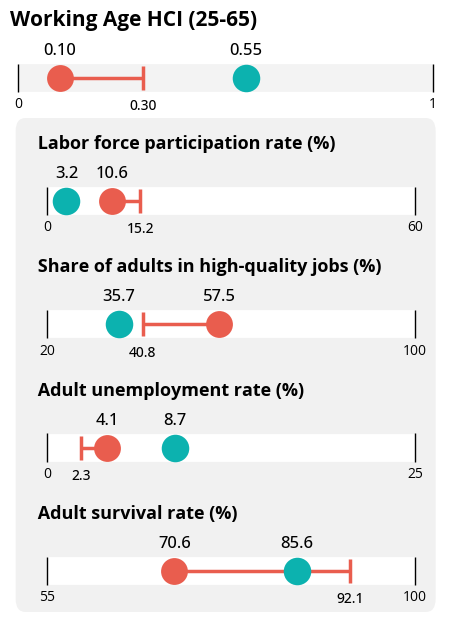

In [153]:
stage_params = {
    'title': 'Working Age HCI (25-65)',
    'x_main': 0.1,
    'x_top95': 90,
    'x_region': 0.3,
    'x_income': 0.55,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
}
c1_params = {
    'title': 'Labor force participation rate (%)',
    'x_main': 10.6,
    'x_top95': 9999,
    'x_region': 15.2,
    'x_income': 3.2,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (0, 60),
    'round_decimals': 1
}
c2_params = {
    'title': 'Share of adults in high-quality jobs (%)',
    'x_main': 57.5,
    'x_top95': 99999999,
    'x_region': 40.8,
    'x_income': 35.7,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (20, 100),
    'round_decimals': 1
}
c3_params = {
    'title': 'Adult unemployment rate (%)',
    'x_main': 4.1,
    'x_top95': 99999999,
    'x_region': 2.3,
    'x_income': 8.7,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (0, 25),
    'round_decimals': 1
}
c4_params = {
    'title': 'Adult survival rate (%)',
    'x_main': 70.6,
    'x_top95': 99999999,
    'x_region': 92.1,
    'x_income': 85.6,
    'components': [0.8200000000000001, 0.18],
    'component_labels': ('Education', 'Health'),
    'xlim': (55, 100),
    'round_decimals': 1
}

fig, ax = plot_hci_block(
    stage_params=stage_params,
    c1_params=c1_params,
    c2_params=c2_params,
    c3_params=c3_params,
    c4_params=c4_params,
)   
fig.savefig(rf"{output}\HCI_stage4.jpg", dpi=600, bbox_inches='tight', pad_inches=.25, edgecolor="black")


In [154]:
# -------------------------------------------------------------
# 4. Combine Figures
# -------------------------------------------------------------
from PIL import Image

# Open the two images
img1 = Image.open(rf"{output}\HCI_stages.jpg")
img2 = Image.open(rf"{output}\stacked_two_line_decomposition.jpg")

# Make sure they have the same width
assert img1.width == img2.width, "Images must have the same width"

# Create a new blank image with combined height
total_height = img1.height + img2.height - 200
result = Image.new("RGB", (img1.width, total_height))

# Paste images one below the other
result.paste(img1, (0, 0))
result.paste(img2, (0, img1.height - 150))

# Save or show the result
result.save("combined.jpg")